# RETINAL SCANNER Model 1

## Binary Retinal Image Classifier - 
## Normal vs Unhealthy (45 Diseases pooled) 

### August 2022

## *PROBLEM STATEMENT*: This is the first of 5 models developed at part of the Retinal Scanner Project.  


## MODEL 1 is a binary image classifier developed to screen retinal images as healthy or diseased, using 3200 images with 45 different diseases present.##


Models 2-5 were later developed, to offer different tools for detecting single diseases (models 2, 3, 4) or one of five key diseases (Model 5).  Therefore there are 5 models associated with this project, which may be applied separately or together to evaluate image sets.

The models are based on a transfer learning model using InceptionV3 convolutional neural network (CNN) model, Python and Tensorflow.

**The following code was run within the Google Colab Environment.**

In [1]:
import os

In [2]:
# this is available within Google Colab
from google.colab import drive

ImportError: No module named 'google.colab'

In [3]:
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
cd/gdrive/My Drive/Retimages/Train/

/gdrive/My Drive/Retimages/Train


In [3]:
# import libraries and packages
import numpy as np 
import pandas as pd
import zipfile
import csv
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from google.colab.patches import cv2_imshow
import random
import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import shutil

# Import skimage modules
import skimage
import skimage.io
from matplotlib import pyplot as plt

from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist
from skimage.exposure import equalize_hist

from pathlib import Path

ImportError: No module named 'google.colab'

# PART 1 - Data Preparation and Organization


The 3200 colour images from the kaggle data set (Retinal Disease Classification, by Larxel) were already downloaded and grouped into folders (Train, Validation, Test groups, with subfoders 'normal' and 'abnormal' within each of the 3 groups). This was done in **Part 1 data EDA Notebook** separately. Work is being done using my Google Drive and Google Colab to allow better computational speed.

There were 2560 disease images and 640 healthy images, therefore it was an imbalanced dataset for Model 1 and data augmentation was used to increase the number of healthy images to be similar to disease image datasets.

*NOTE: Initial modeling of the dataset was done (not shown), and then images were pre-processed and results were greatly improved (recall, precision, accuracy). Therefore, only the Model 1 results with pre-processed images are coded here.*

The following creates copies of images, applying pre-processing based on contrast histogram equalization (EQH). 

Grouping Training images into separate folders per class (0 Normal, 1 Disease) within Retimages/Train/TrainEQH directory on Google Colab.

Similarly, Validation images were grouped into subfolder per 2 classes, within Retimages/Validation/ValidEQH, and Test images grouped into Retimages/Test/TestEQH.


# THIS TEXT IS FOR MODEL 2 and ONWARDS:
**The first model (MODEL 1: Binary Classifier with all 45 diseases included) used all 3200 images (2560 with one or more diseases present, and 640 healthy images). However, for subsequent models 2-5, I worked in MS Excel to quickly filter out all images with multiple disease conditions and develop a separate label CSV file to be used for Train, Validation, and Test sets for that modeling run. This was done to aid computer in identifying each disease of interest and avoiding confusion between multiple diseases in the same eye.**

In [ ]:
# set random seed
tf.random.set_seed(42)

In [22]:
# Preprocessing function to apply to all images

def hist_equalize(im, clahe=True, bgr=True):
    # Equalize histogram on BGR image 'im' with im.shape(n,m,3) and range 0-255
    yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YUV if bgr else cv2.COLOR_RGB2YUV)
    if clahe:
        c = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        yuv[:, :, 0] = c.apply(yuv[:, :, 0])
    else:
        yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])  # equalize Y channel histogram
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR if bgr else cv2.COLOR_YUV2RGB)  # convert YUV image to RGB


In [41]:
cd/gdrive/My Drive/Retimages/Train/Training

/gdrive/My Drive/Retimages/Train/Training


In [ ]:
# Sets up origin/destination path for copying files and transforming them.

# applying hist_equalize to all images (Train/Validation/Test, and Normal/Abnormal)
from skimage import data, img_as_float
from skimage import exposure

#import cv2
from tensorflow.python.keras.utils.data_utils import Sequence
import warnings
warnings.filterwarnings("ignore")

destination_path = '/gdrive/My Drive/Retimages/Validation/ValidEQH/1Abnormal/'
origin_path = '/gdrive/My Drive/Retimages/Validation/Valid/1Abnormal/'

format_of_your_images = '.png'
all_the_files = Path(origin_path).rglob(f'*{format_of_your_images}')

In [ ]:
# This transforms images using histogram equalization.

for f in all_the_files:
  img_in = cv2.imread(str(f))
  #  transformation
  img_histeq = hist_equalize(img_in)
  #writing to target folder
  cv2.imwrite(f'{destination_path}/{f.name}', img_histeq)

In [49]:
cd/gdrive/My Drive/Retimages/

/gdrive/My Drive/Retimages


In [20]:
# Augments the number of Normal images for the Training Set, to rebalance classes as needed.

# This was done iteratively for each Normal set (Train, Valid),
# as there were far more Diseased images than Normal.

from keras.preprocessing.image import ImageDataGenerator
from skimage import io
datagen = ImageDataGenerator(        
        rotation_range = 40,
        vertical_flip = True,
        horizontal_flip = True,
        brightness_range = (1, 1.4))
import numpy as np
import os
from PIL import Image

# augmenting Normal Training set of 134 pics:
image_directory = os.path.join('./Training/TrainEQH/0Normal/')
dataset = []
my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):    
    if (image_name.split('.')[1] == 'png'):        
        image = io.imread(image_directory + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((2144,1424)) 
        dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=10,
                          save_to_dir= os.path.join('./Training/TrainEQH/aug2nd/'),
                          save_prefix='dr4',
                          save_format='png'):    
    i += 1    
    if i > 13:        
        break

In [ ]:
# Augments the number of normal images for the Validation Set

# augmenting Normal Validation set of 134 pics:
image_directory = os.path.join('./Validation/ValidEQH/0Normal/')
dataset = []
my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):    
    if (image_name.split('.')[1] == 'png'):        
        image = io.imread(image_directory + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((2144,1424)) 
        dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=10,
                          save_to_dir= os.path.join('./Validation/ValidEQH/aug2nd/'),
                          save_prefix='dr4',
                          save_format='png'):    
    i += 1    
    if i > 13:        
        break

In [51]:
# count files per group
train_abnormal_dir = os.path.join('./Train/TrainEQH/1Abnormal')
train_normal_dir = os.path.join('./Train/TrainEQH/0Normal')
train_abnormal_names = os.listdir(train_abnormal_dir)
train_normal_names = os.listdir(train_normal_dir)
print('total training images with abnormalities:', len(os.listdir(train_abnormal_dir)))
print('total training images of normal eyes:', len(os.listdir(train_normal_dir)))

total training images with abnormalities: 1519
total training images of normal eyes: 1548


In [52]:
validation_abnormal_dir = os.path.join('./Validation/ValidEQH/1Abnormal')
validation_normal_dir = os.path.join('./Validation/ValidEQH/0Normal')
validation_abnormal_names = os.listdir(validation_abnormal_dir)
validation_normal_names = os.listdir(validation_normal_dir)
print('total validation images with abnormalities:', len(os.listdir(validation_abnormal_dir)))
print('total validation images of normal eyes:', len(os.listdir(validation_normal_dir)))

total validation images with abnormalities: 505
total validation images of normal eyes: 508


In [53]:
test_abnormal_dir = os.path.join('./Test/TestEQH/1Abnormal')
test_normal_dir = os.path.join('./Test/TestEQH/0Normal')
test_abnormal_names = os.listdir(test_abnormal_dir)
test_normal_names = os.listdir(test_normal_dir)
print('total Test images with abnormalities:', len(os.listdir(test_abnormal_dir)))
print('total Test images of normal eyes:', len(os.listdir(test_normal_dir)))

total Test images with abnormalities: 506
total Test images of normal eyes: 401


The dataset was presplit into train:validation:test sets with 60/20/20 ratios, from the kaggle website. The ratio of healthy to disease eye images was maintained the same in train, test and validation sets.

## Image Data Generators

In [ ]:
# Contrast Equalized images were used for the model.
# Images imported here

height = 178
weight = 268
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 25,
                                   brightness_range=(1,1.3),
                                   vertical_flip = True,
                                   horizontal_flip = True,
                                   fill_mode='constant',cval=1)


train_generator = train_datagen.flow_from_directory('./Train/TrainEQH', 
                                                    target_size=(height,weight), 
                                                    color_mode='rgb',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode='categorical')

Found 3067 images belonging to 2 classes.


In [ ]:
# define x_train and y_train from train generator: 
x_tr, y_tr = train_generator.next() 

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory('./Validation/ValidEQH', 
                                                              target_size=(height,weight),
                                                              color_mode='rgb',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              class_mode='categorical')

Found 1045 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'0Normal': 0, '1Abnormal': 1}

In [ ]:
validation_generator.class_indices

{'0Normal': 0, '1Abnormal': 1}

# Pretrained CNN Model

In [ ]:
# Load pretrained model libraries
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
# load InceptionNetV3 model
model=InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(height,weight,3))

87924736/87910968 [==============================] - 1s 0us/step


# Transfer Learning Model

In [ ]:
# Freeze all the layers in the base model
for layer in model.layers:
    layer.trainable = False

# remove last 2 layers of base InceptionV3 model
front_output = model.layers[-2].output

# Dropout Layer
dl_output = Dropout(0.1)(front_output) # to be tuned

# add flatten layer and dense fully connected layers
flat_output = Flatten()(dl_output)
d1 = Dense(256, activation='relu')(flat_output)
d2 = Dense(48, activation='relu')(d1)
d3 = Dense(12, activation='relu')(d2)

# add output layer
output = Dense(2, activation='softmax')(d3)  

# create final model object
model = Model(inputs=model.input, 
              outputs=output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 267, 402, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 133, 200, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 133, 200, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### Training the Model

In [ ]:
# compile the InceptionV3 model with RMSprop
from tensorflow.keras.callbacks import EarlyStopping
n_epochs = 13
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0.8,decay=0.15,centered=True),
              loss=[tf.keras.losses.BinaryCrossentropy()],
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.45),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])

In [ ]:
# Use an early stopping callback
early_stop = EarlyStopping(monitor='loss', 
                           patience=5, 
                           mode='min', 
                           verbose=1)

In [ ]:
history = model.fit(train_generator,
                    epochs=n_epochs,
                    validation_data = validation_generator,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stop])

Epoch 1/10
96/96 [==============================] - 705s 7s/step - loss: 0.3307 - binary_accuracy: 0.8507 - auc_1: 0.9337 - val_loss: 0.3174 - val_binary_accuracy: 0.8589 - val_auc_1: 0.9397
Epoch 2/10
96/96 [==============================] - 522s 5s/step - loss: 0.3073 - binary_accuracy: 0.8606 - auc_1: 0.9425 - val_loss: 0.3264 - val_binary_accuracy: 0.8536 - val_auc_1: 0.9347
Epoch 3/10
96/96 [==============================] - 522s 5s/step - loss: 0.2936 - binary_accuracy: 0.8647 - auc_1: 0.9475 - val_loss: 0.3044 - val_binary_accuracy: 0.8660 - val_auc_1: 0.9435
Epoch 4/10
96/96 [==============================] - 517s 5s/step - loss: 0.2818 - binary_accuracy: 0.8715 - auc_1: 0.9518 - val_loss: 0.3016 - val_binary_accuracy: 0.8636 - val_auc_1: 0.9452
Epoch 5/10
96/96 [==============================] - 516s 5s/step - loss: 0.2778 - binary_accuracy: 0.8707 - auc_1: 0.9527 - val_loss: 0.2842 - val_binary_accuracy: 0.8770 - val_auc_1: 0.9518
Epoch 6/10
96/96 [===========================

# Test Set

In [ ]:
cd/gdrive/My Drive/Retimages/Test

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory('./Test/TestEQH',
                                                  target_size=(height,weight),
                                                  color_mode='rgb',
                                                  batch_size=907,
                                                  class_mode='categorical')

X_test, y_test = test_generator.next()

Found 907 images belonging to 2 classes.


# Model Predictions and Evaluation

In [ ]:
# Examine test accuracy
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0],round(4))
print('Test accuracy:', score[1],round(4))

29/29 [==============================] - 5s 109ms/step - loss: 0.2983 - binary_accuracy: 0.8754 - auc_1: 0.9448
Test loss: 0.2983150780200958 4
Test accuracy: 0.8754134774208069 4


In [ ]:
# Generate predictions
predictions = model.predict(X_test)

In [ ]:
# Grab a batch of images from our validation generator: 
x, y = validation_generator.next() 

In [ ]:
# Our images labels are one-hot encoded, lets convert them to ordinal encoding
labels = np.argmax(y, axis=0)

In [ ]:
# Calculate the predictions
predict_probas = model.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

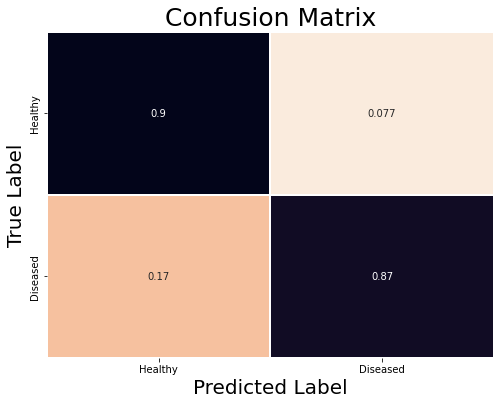

In [ ]:
# Construct the confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Convert our test labels from one-hot encoding to label encoding
y_test_labels = np.argmax(y_test,axis=1)

conf_mat = confusion_matrix(y_test_labels, y_predict)
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize = (8,6))
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=1,
            xticklabels=("Healthy","Diseased"),
            yticklabels=("Healthy","Diseased")
            
           )
plt.title('Confusion Matrix - Binary Classifier (45 Diseases)',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

The above matrix shows good accuracy, recall and precision for this binary classifier model. We will now look at the F1 score (harmonized mean of recall and precision), and we will plot accuracy of Train and Validation sets.

In [ ]:
# Obtain the F1 score
print('F1 Score: %.3f' % f1_score(y_test_labels, y_predict))

F1 Score: 0.889


In [ ]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Retinal Image Health - Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(0,18,3))
plt.legend(['train acc', 'validation acc'])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Retinal Image Health - Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,18,3))
plt.legend(['train loss', 'val loss'])
plt.show()

NameError: ignored

In [ ]:
# save model
model.save('Eye_Binary_45Disease_Inception_eq_28Jul2022.h5')

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#print(classification_report, 0=Normal, 1=Diseased')
from sklearn.metrics import classification_report

report_initial = classification_report(y_test_labels, y_predict)
print(report_initial)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       401
           1       0.92      0.87      0.89       506

    accuracy                           0.88       907
   macro avg       0.88      0.88      0.88       907
weighted avg       0.88      0.88      0.88       907



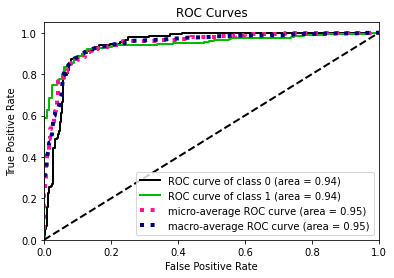

<Figure size 1400x1200 with 0 Axes>

In [ ]:
# Plot of ROC Curves per Class

from IPython.core.pylabtools import figsize
import scikitplot as skplt
import matplotlib.pyplot as plt
#y_test_labels = # ground truth labels
skplt.metrics.plot_roc(y_test_labels, predict_probas)
plt.figure(figsize=(14,12),dpi=100)
plt.show()

#### Incorrectly Predicted Images
As our final evaluation of our model, we will look at the images that were incorrectly predicted to see if there are any patterns.

In [ ]:
import math

incorrect_photos = y_test_labels != y_predict

num_images = np.count_nonzero(incorrect_photos)
columns = 2
rows = math.ceil(num_images / columns)

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(10, 3.5*rows))

axes = axes.flatten()

for i, image in enumerate(X_test[incorrect_photos]):
    axes[i].imshow(image, cmap='gray')

    # Get predicted label
    predicted_label = labels[y_predict[incorrect_photos][i]]
    
    # Get actual label
    true_label =  labels[y_test_labels[incorrect_photos][i]]

    #Get filename of image
    filenam = test_generator.filenames[i]
    x=filenam[8:]     

    # Set the title of the subplot
    axes[i].set_title(f"\n IMAGE: {x} \n Predicted: {predicted_label}\n True: {true_label}")
    
    # Hide the x and y ticks to make 
    axes[i].set_xticks([]) 
    axes[i].set_yticks([])
    
fig.tight_layout()
# Hide unused subplots
for i in range(num_images, rows*columns):
    fig.delaxes(axes[i])

plt.show()

Images above were examined for physical attributes (colour, markings, brightness, specific features related to specific diseases), trends or noticeable patterns in terms of predicted vs True classes.
No observed pattern was seen in terms of physical appearance of misclassed images, or a pattern in terms of which images were predicted in one class but were in fact another class.

In [ ]:
# Count all misclassified images in test set
MISCLASSIFIED = num_images

# Accuracy calculations
total = Num_Test_Images
num_correct = total - (MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print(f"Number of misclassified images = {MISCLASSIFIED}  out of {total}")

This model provided great binary classification results for evaluating if eyes are healthy or diseased. 

Subsequently, I conducted modeling with only the images from the 16 most frequent diseases. I also conducted modeling with only the top 8 most common diseases in the dataset, and I report these results as Model 1b in the Report (no notebook provided as it was similar to this current report with 45 diseases).

# Concluding Statements

Therefore we had 88% test accuracy in accurately predicting whether a retinal image was healthy or diseased, based on 45 potential diseases present.

We also had 94% Recall (our key metric for this medical-related question, since we do not want to miss out positive disease cases as this would mean that a person needing care would not get it). So we only missed 6% of cases where diseased retinas were presented and we rated them normal.  We had 88% Precision as well.

In conclusion, our CNN transfer learning model with InceptionV3 was effective in detecting diseases, despite the fact that there were 45 types of disease, some of which with only a few images each type. Also, the authors had added noise to the images to make classification more difficult.

Further modeling was conducted with Model 1B(see Report; no notebook). 

Additionally, Model 2 (DR specific classifier), Model 3 (ARMD specific classifier), Model 4 (ODC specific Classifier), and Model 5 (multiclass model with the 5 of the most common diseases) were developed and tuned to optimize recall and precision. These are provided in separate notebooks, and also summarized in the Report.